In [336]:
# asplund = np.array([8.69,8.06,7.55,7.51,7.12,6.30,4.97]) # Asplund et al. 2021
# asplund_err = np.array([0.04,0.05,0.03,0.03,0.03,0.03,0.05]) # Asplund et al. 2021
# ZX_sol = 0.0187 # (Z/X) Asplund et al. 2021
# massH = 1.008 # IUPAC
# atmmass = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867]) # IUPAC

# mass_ratio = atmmass/massH    
# XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
# sal_a = np.sum(XZ_k)
# sal_b = 1 - sal_a

# print(sal_a)
# print(sal_b)

0.6594921942359003
0.34050780576409967


In [337]:
np.log10(2.74)

0.437750562820388

In [505]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
# from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a RGB star's mass, extinction, and age using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
        
    def __init__(self,teff,logg,abundances,photometry,distance,isochrones):
        '''
        Inputs:
        ------
            teff:
            logg:
            abundances:
            photometry:
            distance:
            isochrones:
        '''
        
        ### Observed Quantities
        
        # Spectroscopic parameters
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        
        self.logg = logg[0] # surface gravity
        self.logg_err = logg[1] # surface gravity error
        
        # Salaris corrected [Fe/H]
        fehs = np.array([abundances[0,0],abundances[0,1]]) 
        afes = np.array([abundances[1,0],abundances[1,1]])
        self.salfeh, salfeh_err = self.salaris(fehs,afes)
        
        # Photometry
        self.phot = photometry[:,0] # photometry
        self.phot_err = photometry[:,1] # photometry errors
        self.distance = distance # distance in parsecs
        self.distmod = 5.0*np.log10(distance)-5.0 # distance modulus
        
        ### PARSEC isochrones
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        # Find unique ages and the beginning and ending indices 
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        ### Effective wavelengths and extinction parameters
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        self.rv = 3.1 # Rv value (=Av/E(B_V))
        
        self.alak = np.array([self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']),
                          self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']),
                          self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']),
                          self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']),
                          1.0])
        
        ### Solar Paramters
        self.mbolsun = 4.74 # bolometric magnitude IAU 2015 Resolution B2
        self.teffsun = 5773 # +/- 16 K Asplund et al. 2021
        self.loggsun = np.log10(27400.) # logg cgs https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
        self.masssun = 1.988500*10**33 # mass in g https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
        
    def salaris(self,feh,afe):
        '''
        Calculate the Salaris corrected [Fe/H] of a star
        
        Inputs:
        ------
            feh: [Fe/H] and error
            afe: alpha abundance and error
        
        Outputs:
        -------
            salfeh: Salaris corrected [Fe/H]
            salfeh_err: error in Salaris corrected [Fe/H]
        '''
        
        # asplund = np.array([8.69,8.06,7.55,7.51,7.12,6.30,4.97]) # Asplund et al. 2021
        # asplund_err = np.array([0.04,0.05,0.03,0.03,0.03,0.03,0.05]) # Asplund et al. 2021
        # ZX_sol = 0.0187 # (Z/X) Asplund et al. 2021
        # massH = 1.008 # IUPAC
        # atmmass = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867]) # IUPAC
        # mass_ratio = atmmass/massH    
        # XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
        # sal_a = np.sum(XZ_k) = 0.6594921942359003
        # sal_b = 1 - sal_a = 0.34050780576409967
        
        sal_a = 0.6594921942359003
        sal_b = 0.34050780576409967
        
        salfeh = feh[0]+np.log10(sal_a*(10**(afe[0]))+sal_b)
        salfeh_err = np.sqrt(feh[1]**2+((1-sal_b/(sal_a*(10**(afe[0]))+sal_b))*afe[1])**2)
        
        return salfeh, salfeh_err 
    
    #################
    ### Utilities ###
    #################
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of a dataset
        
        Input:
        -----
            data: data to calculate the mad of 
        
        Output:
        ------
            mad: MAD
        '''
        mad = np.nanmedian(np.abs(data-np.nanmedian(data)))
        return mad
    
    def closest(self,data,value):
        '''
        Find the closest value in data given a value

        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''

        data = np.asarray(data)
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data: data to search through 
            value: value of interest

        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''

        data = np.asarray(data)
        close1 = self.closest(data,value)
        data = data[np.where(data!=close1)]
        close2 = self.closest(data,value)

        return close1,close2
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a
            
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
            
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    ##############################
    ### Bolometric Corrections ###
    ##############################
    
    def bc_bp(self,teff):
        '''
        Bolometric correction for the BP band as a function of Teff.
        
        Input:
        -----
            teff: effective temperature of a star
            
        Output:
        ------
            bcbp: BP bolometric correction
        '''
        
        lgteff = np.log10(teff)
        a,b,c,d,e = [-366252.00276,396402.30607,-160908.04863,29032.51483,-1964.55784]
        bccp = a+b*lgteff+c*lgteff**2+d*lgteff**3+e*lgteff**4
        return bccp
    
    def bc_rp(self,teff):
        '''
        Bolometric correction for the RP band as a function of Teff.
        
        Input:
        -----
            teff: effective temperature of a star
            
        Output:
        ------
            bcrp: RP bolometric correction
        '''
        
        lgteff = np.log10(teff)
        a,b,c,d,e = [-239151.74710,260953.83317,-106795.43722,19427.92610,-1325.55340]
        bcrp = a+b*lgteff+c*lgteff**2+d*lgteff**3+e*lgteff**4
        return bcrp
    
    def bc_j(self,teff):
        '''
        Bolometric correction for the J band as a function of Teff.
        
        Input:
        -----
            teff: effective temperature of a star
            
        Output:
        ------
            bcj: J bolometric correction
        '''
        
        lgteff = np.log10(teff)
        a,b,c,d,e = [38018.77275,-41148.61302,16689.69781,-3006.09184,202.85370]
        bcj = a+b*lgteff+c*lgteff**2+d*lgteff**3+e*lgteff**4
        return bcj
    
    def bc_h(self,teff):
        '''
        Bolometric correction for the H band as a function of Teff.
        
        Input:
        -----
            teff: effective temperature of a star
            
        Output:
        ------
            bch: H bolometric correction
        '''
        
        lgteff = np.log10(teff)
        a,b,c,d,e = [45955.99702,-50388.99909,20709.73902,-3780.71392,258.63999]
        bch = a+b*lgteff+c*lgteff**2+d*lgteff**3+e*lgteff**4
        return bch
    
    def bc_k(self,teff):
        '''
        Bolometric correction for the K band as a function of Teff.
        
        Input:
        -----
            teff: effective temperature of a star
            
        Output:
        ------
            bck: BP bolometric correction
        '''
        
        lgteff = np.log10(teff)
        a,b,c,d,e = [15696.89389,-17008.41117,6910.49256,-1247.06696,84.29995]
        bck = a+b*lgteff+c*lgteff**2+d*lgteff**3+e*lgteff**4
        return bck
    
    ###############################
    ### Theoretical Calulations ###
    ###############################
    
    def app_mags(self,teff,mass,ak):
        '''
        Calculate the apparent magnitudes of a star in the BP, RP, J, H, and K bands.
        
        Inputs:
        ------
            teff: effective temperature of a star
            mass: mass in solar masses
            ak: extinction in the K band
            
        Output:
        ------
            calc_mags: calculated apparent magnitudes in the BP, RP, J, H, and K bands
        '''
        
        # Extinctions and bolomteric corrections for each band
        extincts = self.alak*ak
        bolocorr = np.array([self.bc_bp(self.teff),self.bc_rp(self.teff),self.bc_j(self.teff),
                             self.bc_h(self.teff),self.bc_k(self.teff)])
        
        # Calculate the theoretical apparent magnitudes
        calc_mags = 999999.0*np.ones(len(extincts))
        sunstuff = -2.5*(self.loggsun-4*np.log10(self.teffsun))+self.mbolsun
        for i in range(len(extincts)):
            calc_mags[i] = (-2.5*(np.log10(mass)-self.logg+4*np.log10(self.teff)+self.distmod)-
                            bolocorr[i]+extincts[i]+sunstuff)
            
        return calc_mags
    
    def mass_2_age(self,mass):
        '''
        Calculate the age of a star for a given mass.
        
        Input:
        -----
            mass: mass of a star in solar masses
            
        Output:
        ------
            age: age of a star 
        ''' 
        try:
            # find the closest two mass in the isochrone table
            mass_lo,mass_hi = self.neighbors(self.iso['Mass'],mass)
            iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
            iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

            # lighter mass
            sidx_lo = np.argsort(iso_lo['MH']) # sort by metallicity
            sMH_lo = iso_lo['MH'][sidx_lo] # pick metallicity
            _, uidx_lo = np.unique(sMH_lo,return_index=True) # find unique value indices
            sMH_lo = sMH_lo[uidx_lo] # sorted unique metallicity values
            slogAge_lo = iso_lo['logAge'][sidx_lo][uidx_lo] # sorted unique logAge values

            spl_lo = interp1d(sMH_lo,10**slogAge_lo/10**9) # age as a function of metallicity

            # heavier mass
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_indes=True)
            sMH_hi = sMH_hi[uidx_hi]
            slogAge_hi = iso_hi['logAge'][sidx_hi][uidx_hi]

            spl_hi = interp1d(sMH_hi,10**slogAge_hi/10**9)

            # final spline to get an age
            final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(mass)
            return age
        
        except:
            return 999999.0
        
    #########################
    ### Fitting Functions ###
    #########################
    
    def get_mass_ak(self,guess_masses=np.arange(0.0,5.0),guess_aks=np.arange(0.0,2.0,0.1)):
        '''
        Calculate the mass and K band extinction of a star
        
        Input:
        -----
            guess_masses: trial masses
            guess_aks: trial K band extinctions
        
        Output:
        ------
            calc_mass:
            calc_ak: 
        '''
        
        mass_fit = 999999.0*np.ones((len(guess_masses),len(guess_aks)))
        ak_fit = 999999.0*np.ones((len(guess_masses),len(guess_aks)))
        chi_fit = 999999.0*np.ones((len(guess_masses),len(guess_aks)))
        
        for i in range(len(guess_masses)):
            for j in range(len(guess_aks)):
                
#                 try:
                popt,_ = curve_fit(self.app_mags,self.teff,self.phot,p0=(guess_masses[i],guess_aks[j]),
                                   bounds=((0.,0.),(5.,2.)),method='trf',sigma=self.phot_err,
                                   absolute_sigma=True,maxfev=5000)

                mass_fit[i,j] = popt[0]
                ak_fit[i,j] = popt[1]

                mags_fit = self.app_mags(self.teff,popt[0],popt[1])
                chi_fit[i,j] = np.sum((mags_fit-self.phot)**2/self.phot_err**2)

#                 except:
#                     mass_fit[i,j] = 999999.0
#                     ak_fit[i,j] = 999999.0
#                     chi_fit[i,j] = 999999.0
                    
        
        best_chi = np.squeeze(np.where(chi_fit==np.min(chi_fit)))
        
        mass = mass_fit[best_chi[0],best_chi[1]]
        ak = ak_fit[best_chi[0],best_chi[1]]
        
        return mass, ak
    
    #def get_age()
    
    #def diagnostic_mass_ak(self,lit_mass,lit_ak)
    
    #def diagnostic_age(self,lit) 

In [6]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

In [485]:
from tqdm import tqdm_notebook

# PARSEC

In [510]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','int_IMF','Mini','logAge','logTe','logg','Xc','Xn','Xo','Gmag','G_BPmag',
                  'G_RPmag','Jmag','Hmag','Ksmag','mbolmag']

In [520]:
iso_oM = np.log10(massive['Xo']/10**(8.69-12.0))-massive['MH']
iso_cM = np.log10(massive['Xc']/10**(8.69-12.0))-massive['MH']
iso_nM = np.log10(massive['Xn']/10**(8.69-12.0))-massive['MH']

iso_ages = 10**massive['logAge']/10**9

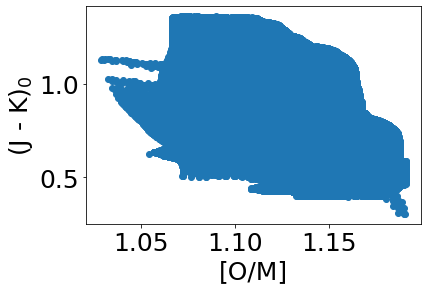

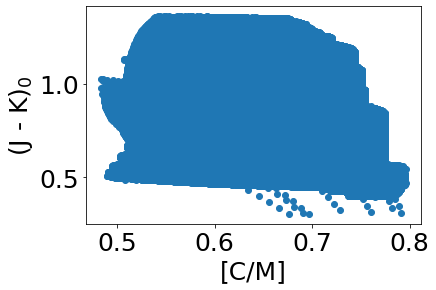

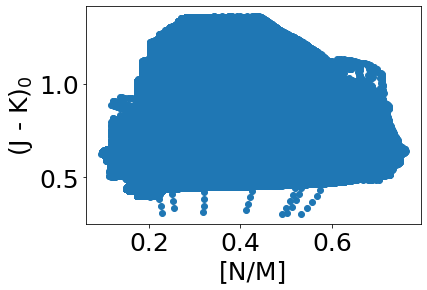

In [523]:
###
plt.scatter(iso_oM[teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut])
plt.xlabel(r'[O/M]')
plt.ylabel(r'(J - K)$_0$')

plt.show()

###
plt.scatter(iso_cM[teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut])
plt.xlabel(r'[C/M]')
plt.ylabel(r'(J - K)$_0$')

plt.show()

###
plt.scatter(iso_nM[teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut])
plt.xlabel(r'[N/M]')
plt.ylabel(r'(J - K)$_0$')

plt.show()

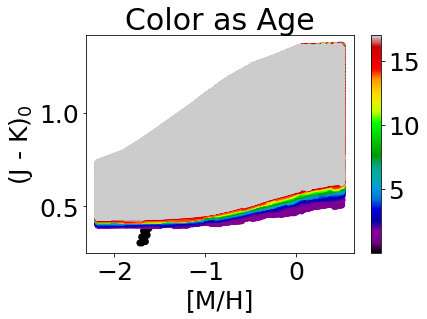

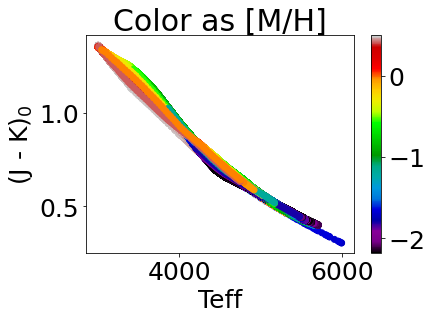

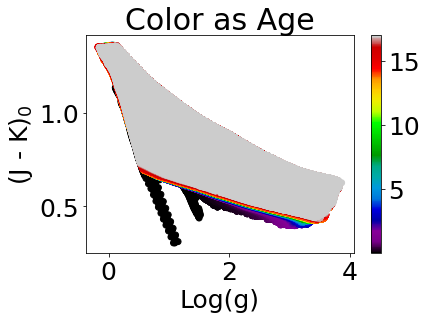

In [527]:
###
plt.scatter(massive['MH'][teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut],
            c=iso_ages[teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'[M/H]')
plt.ylabel(r'(J - K)$_0$')

plt.show()

###
plt.scatter(10**massive['logTe'][teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut],
            c=massive['MH'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.xlabel(r'Teff')
plt.ylabel(r'(J - K)$_0$')

plt.show()

###
plt.scatter(massive['logg'][teffcut],(massive['Jmag']-massive['Ksmag'])[teffcut],
            c=iso_ages[teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'(J - K)$_0$')

plt.show()

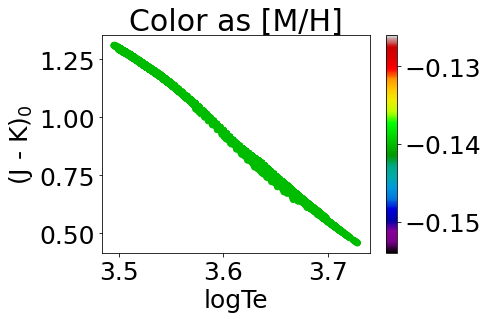

# APOKASC

<ipython-input-8-0a79aeaf0aa8>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


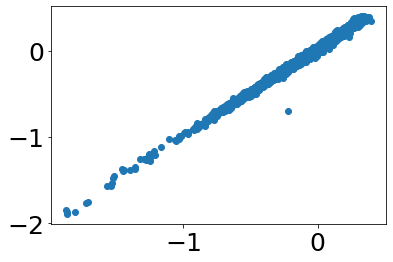

In [8]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [488]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

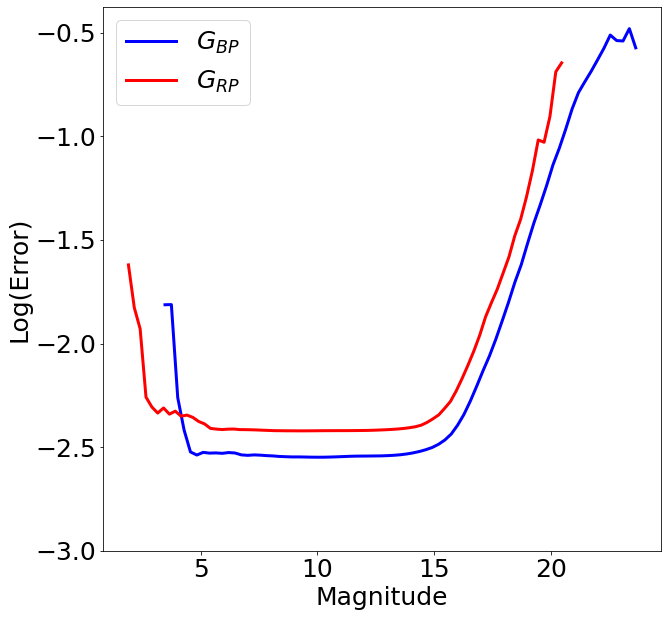

In [489]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Calculate Mass, Ak, and Age

In [506]:
# (teff,logg,abundances,photometry,distance,isochrones)

kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    
    lg = np.array([kdr17['LOGG'][i],kdr17['LOGG_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Astrologium(te,lg,ab,op,di,massive)
    
    
    star_mass, star_ak = CalcAge.get_mass_ak()
#     print(star_mass)
#     print(star_ak)
    kasc_mass[i] = star_mass
    kasc_ak[i] = star_ak
    
    kasc_age[i] = CalcAge.mass_2_age(star_mass)

<ipython-input-506-45b211cca37e>:8: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)
<ipython-input-506-45b211cca37e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


KeyboardInterrupt: 

In [508]:
kasc_ak

array([3.09071976e-05, 3.09108344e-05, 6.98509795e-01, ...,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05])

# Calibration 

FPARAM: Teff, log g, vmicro, [M/H], [C/M], [N/M], [$\alpha$/M], vsini

In [9]:
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

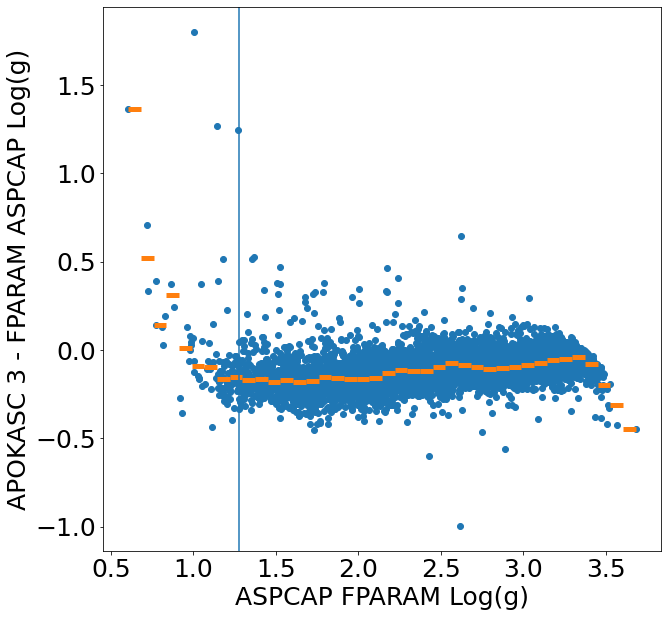

In [64]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True))
bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

plt.figure(figsize=[10,10])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='tab:orange', lw=5.)
plt.axvline(1.2795)
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.show()

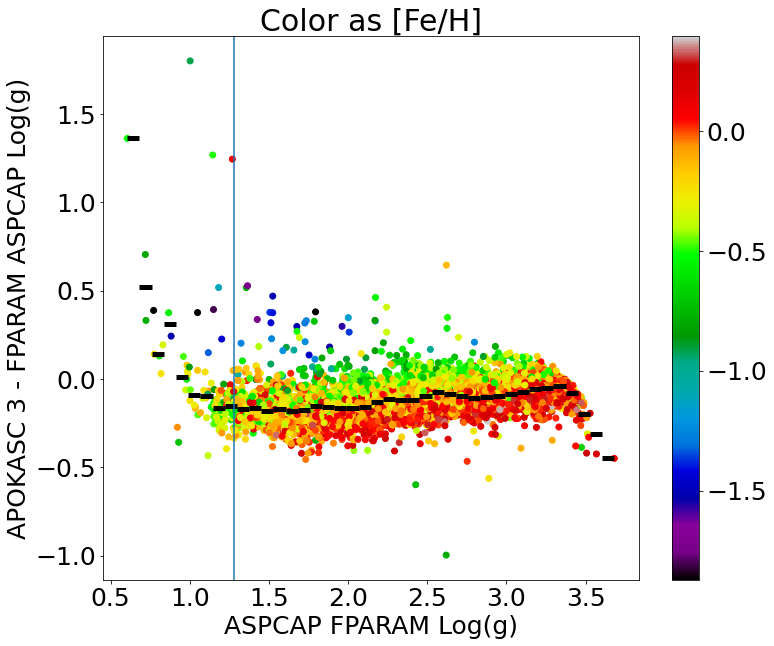

In [65]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True))
bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

plt.figure(figsize=[12,10])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c=kdr17['FE_H'],cmap='nipy_spectral')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
plt.colorbar()
plt.axvline(1.2795)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.show()

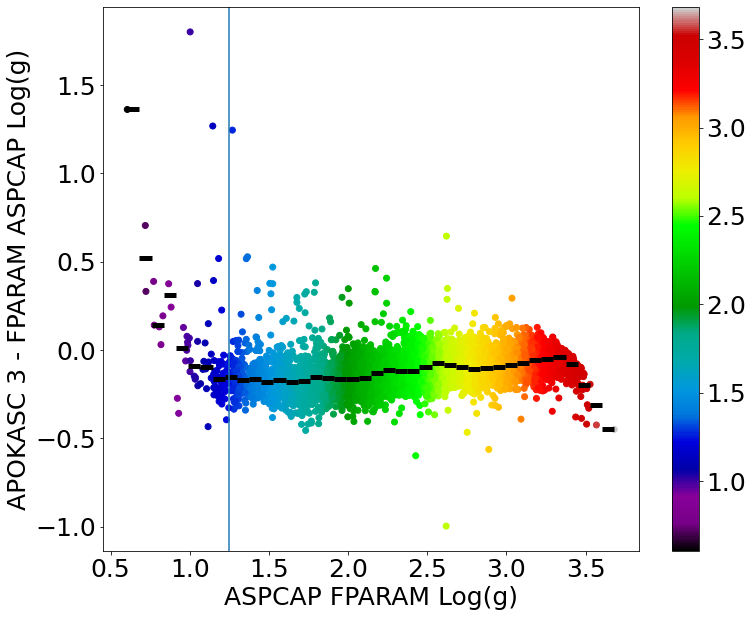

In [66]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True))
bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

plt.figure(figsize=[12,10])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c=kdr17['FPARAM'][:,1],cmap='nipy_spectral')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
plt.colorbar()
plt.axvline(1.25)
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.show()

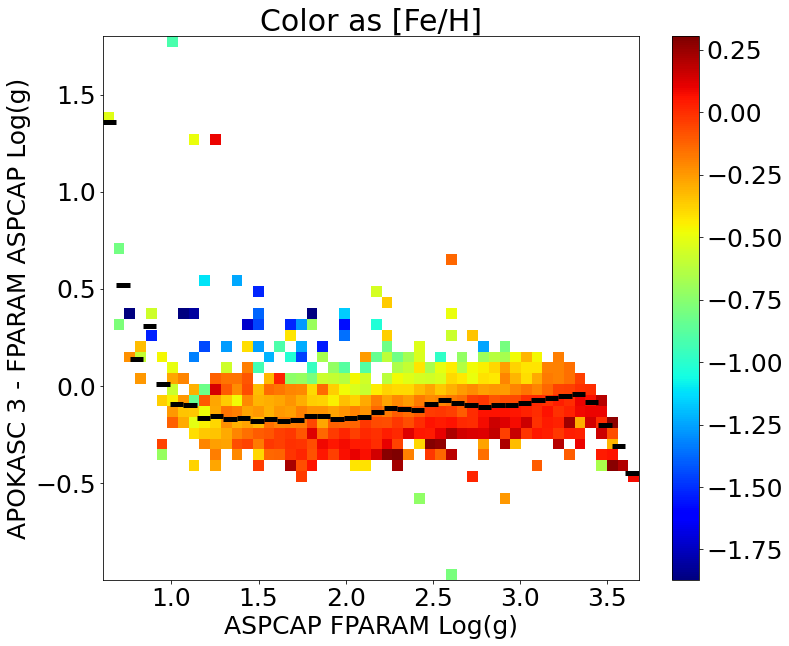

In [449]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                          kdr17['FE_H'][cut],'median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
# plt.axvline(1.2795)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.savefig('../plots/loggresid_feh.pdf',dpi=300,bbox_inches='tight')
plt.show()

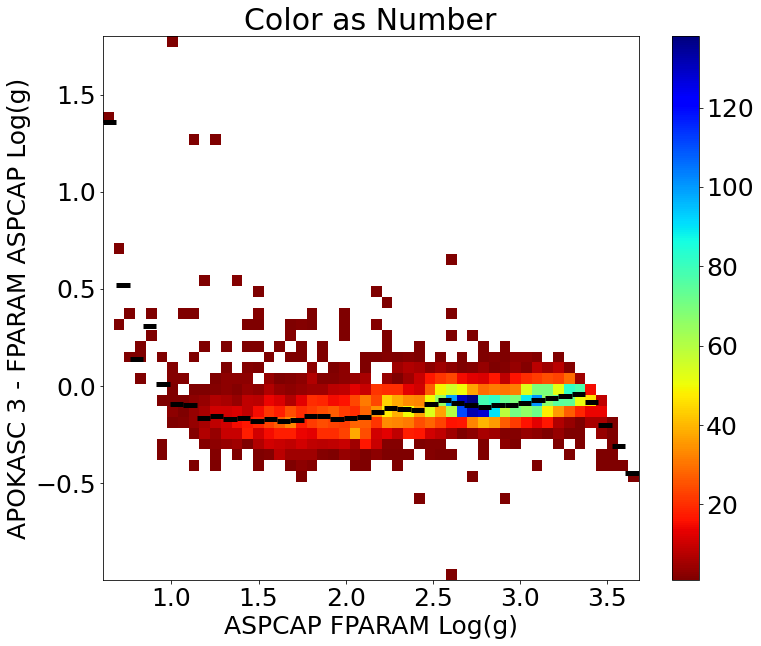

In [536]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                          kdr17['FPARAM'][:,1][cut],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
# plt.axvline(1.2795)
plt.title(r'Color as Number')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.savefig('../plots/loggresid_num.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [537]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

def logg_calib(X,a,b,c,d,e):
    grav,mets = X
    return  a + b*grav + c*grav**2 + d*grav**3 + e*mets

X_fit_calib = ([kdr17['FPARAM'][:,1][cut],kdr17['FE_H'][cut]])

param_labels = np.array(['a','b','c','d','e'])
popt_logg_calib, _ = curve_fit(logg_calib, 
                               (kdr17['FPARAM'][:,1][cut],kdr17['FE_H'][cut]),
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_logg_calib[i]))

Fit Parameters:
a = 0.78228
b = -1.39969
c = 0.62536
d = -0.08488
e = -0.20428


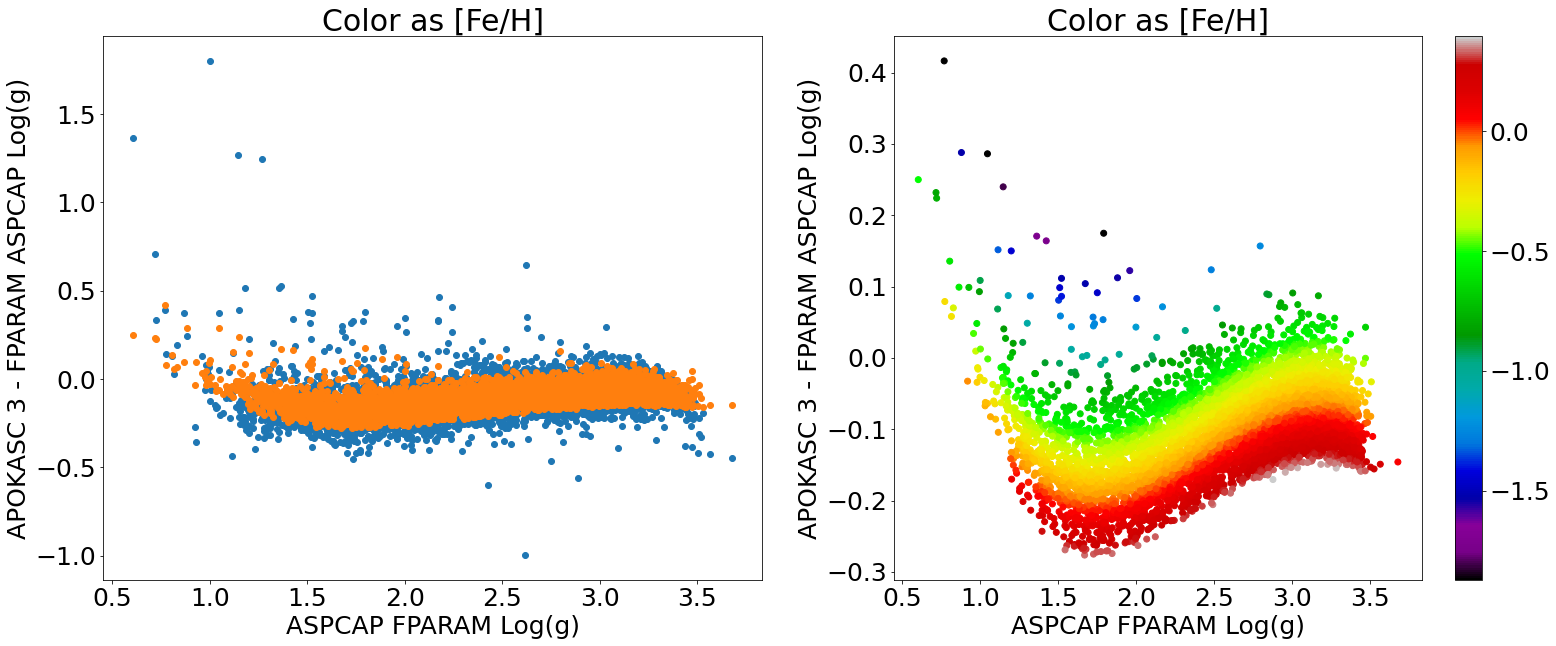

In [451]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))
plt.figure(figsize=[26,10])

plt.subplot(121)
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],c='tab:blue')
X = ([kdr17['FPARAM'][:,1],kdr17['FE_H']])
plt.scatter(kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),c='tab:orange')
# plt.colorbar()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')

plt.subplot(122)
plt.scatter(kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),c=kdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g)')
plt.savefig('../plots/loggresid_calib_results.pdf',dpi=300,bbox_inches='tight')
plt.show()

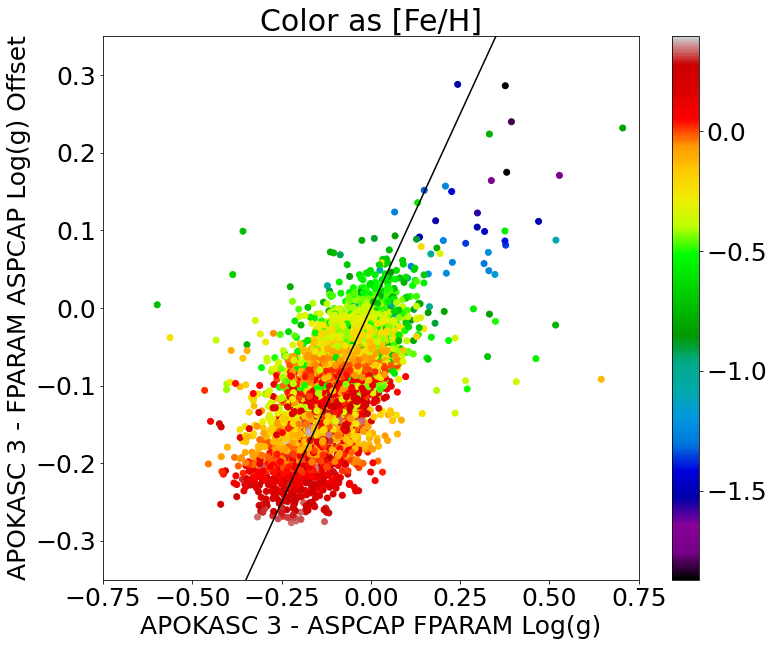

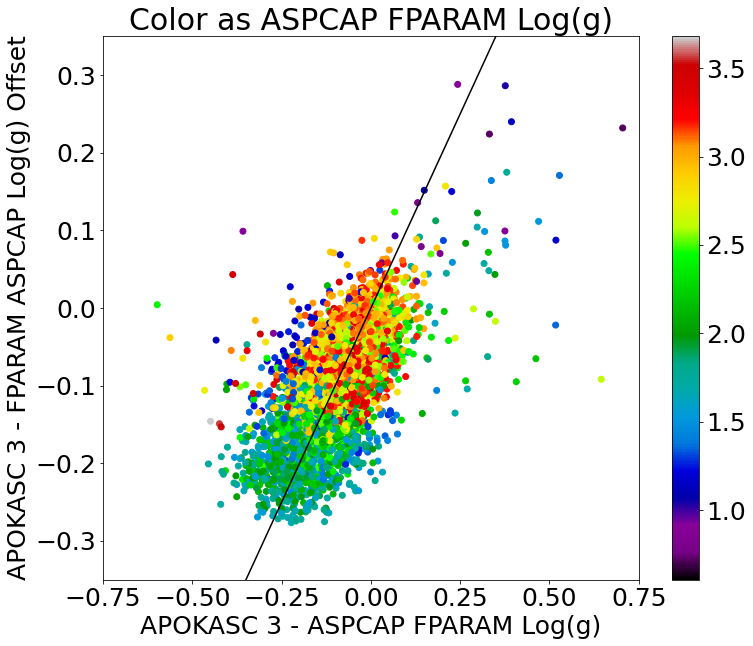

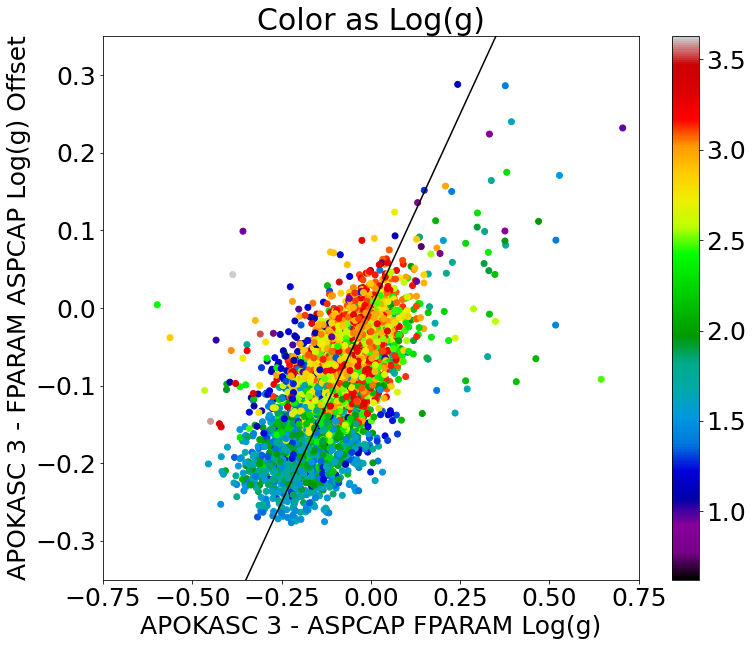

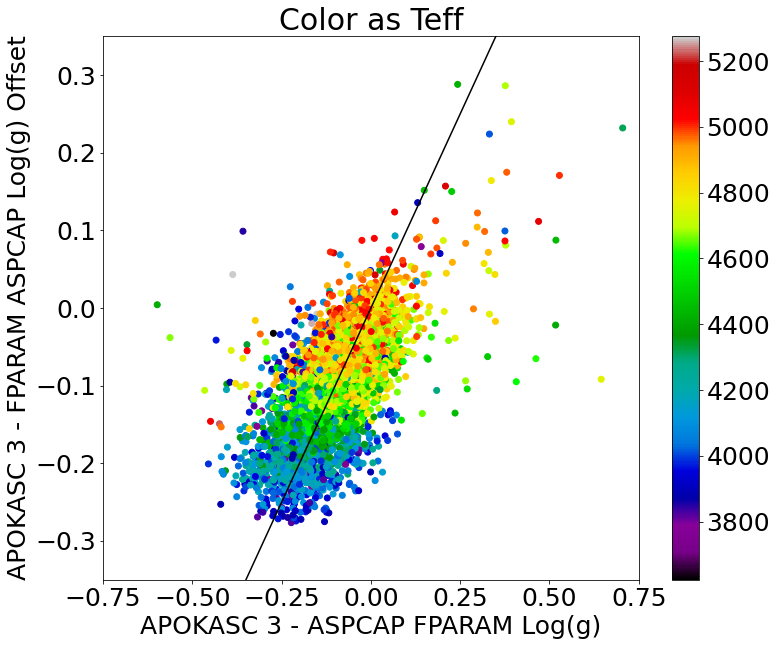

In [163]:
plt.figure(figsize=[12,10])
plt.scatter(k3dr17['Logg']-kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),
            c=kdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-1.0,1.75],[-1.0,1.75],c='k')
plt.ylim(-0.35,0.35)
plt.xlim(-0.75,0.75)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'APOKASC 3 - ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g) Offset')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(k3dr17['Logg']-kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),
            c=kdr17['FPARAM'][:,1],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-1.0,1.75],[-1.0,1.75],c='k')
plt.ylim(-0.35,0.35)
plt.xlim(-0.75,0.75)
plt.title(r'Color as ASPCAP FPARAM Log(g)')
plt.xlabel(r'APOKASC 3 - ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g) Offset')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(k3dr17['Logg']-kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),
            c=kdr17['LOGG'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-1.0,1.75],[-1.0,1.75],c='k')
plt.ylim(-0.35,0.35)
plt.xlim(-0.75,0.75)
plt.title(r'Color as Log(g)')
plt.xlabel(r'APOKASC 3 - ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g) Offset')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(k3dr17['Logg']-kdr17['FPARAM'][:,1],logg_calib(X,*popt_logg_calib),
            c=kdr17['TEFF'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-1.0,1.75],[-1.0,1.75],c='k')
plt.ylim(-0.35,0.35)
plt.xlim(-0.75,0.75)
plt.title(r'Color as Teff')
plt.xlabel(r'APOKASC 3 - ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 - FPARAM ASPCAP Log(g) Offset')
plt.show()

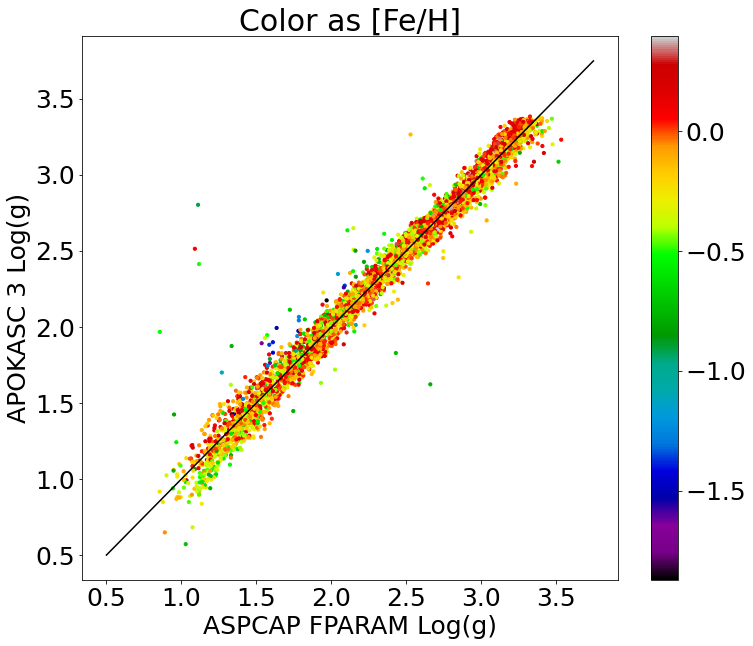

In [164]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['FPARAM'][:,1]+logg_calib(X,*popt_logg_calib),k3dr17['Logg'],
            c=kdr17['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([0.5,3.75],[0.5,3.75],c='k')

plt.xticks([0.5,1,1.5,2.0,2.5,3.0,3.5])
plt.yticks([0.5,1,1.5,2.0,2.5,3.0,3.5])

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 Log(g)')
plt.show()

In [111]:
X_fit_calib[0]

array([2.9229, 3.3329, 2.9402, ..., 2.8531, 1.9482, 2.4125], dtype=float32)

In [102]:
print(np.shape(X_fit_calib))
print(np.shape(X_fit_calib.T))

(2, 6072)
(6072, 2)


In [ ]:
np.shape()

In [99]:
np.shape(X_fit_calib.T)
# np.shape((k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut].T)

(2, 6072)

In [ ]:
# def teff_calib(x,a,b,fteff0,teff0):
#     return np.piecewise(x,[x<fteff0],[lambda x: teff0, lambda x: a*(x**2+fteff0**2)-b*(x-fteff0)+teff0])



bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

# param_labels = np.array(['a','b','fteff0','teff0'])
popt, _ = curve_fit(teff_calib, bin_centers, bin_means, p0 = [-1,1,4500,100])

print('Fit Parameters:')
for i in range(4):
    print(r'{} = {:.5f}'.format(param_labels[i],popt[i]))

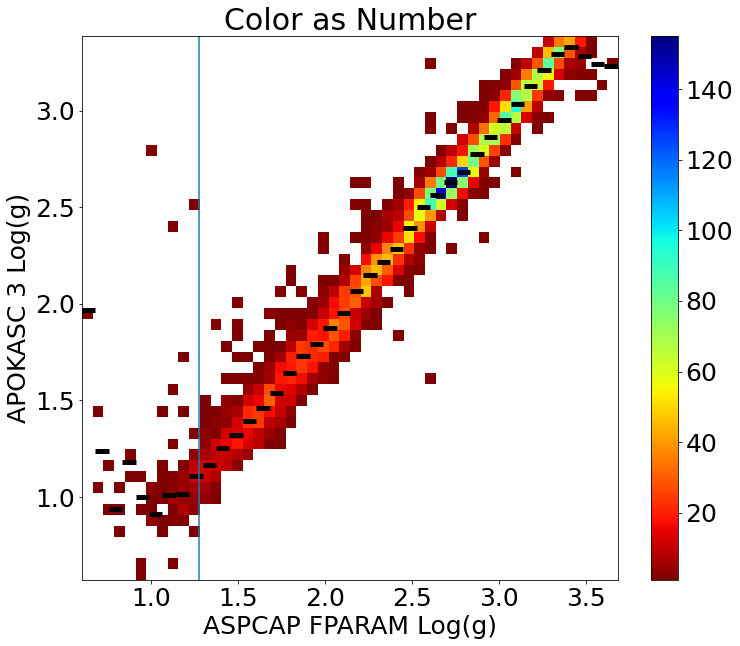

In [69]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],kdr17['FPARAM'][:,1][cut],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')
plt.colorbar()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
plt.axvline(1.2795)
plt.title(r'Color as Number')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC 3 Log(g)')
plt.show()

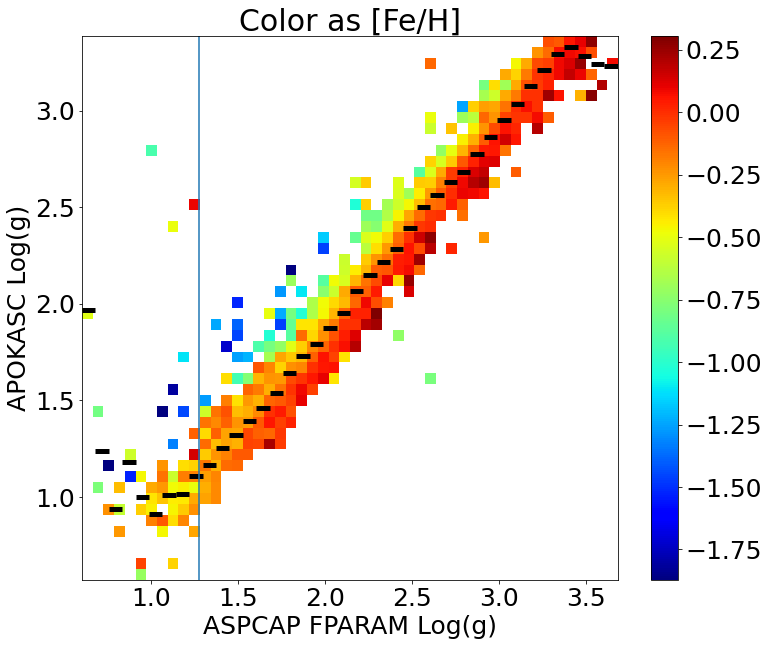

In [70]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],kdr17['FE_H'][cut],
                          statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
plt.axvline(1.2795)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC Log(g)')
plt.show()

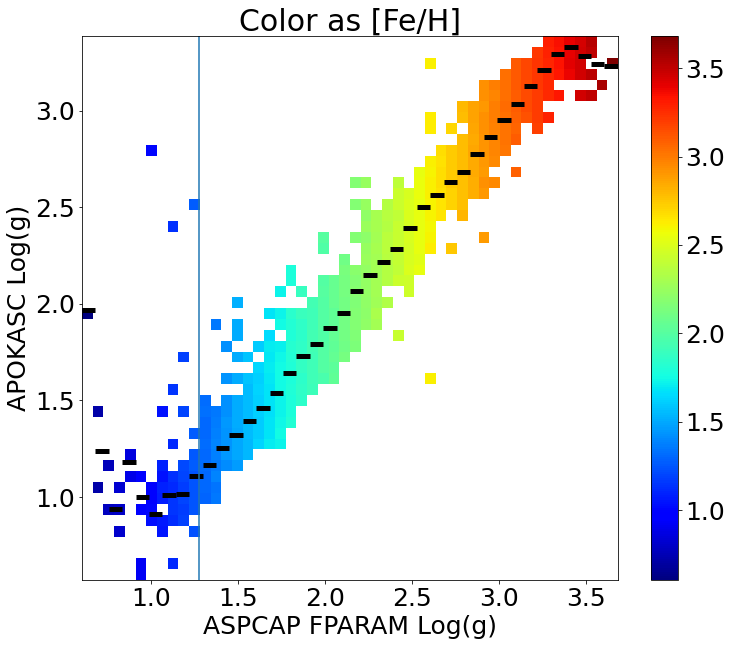

In [72]:
cut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg']-kdr17['FPARAM'][:,1])==True)&
               (np.isfinite(kdr17['FE_H'])==True))

bin_means, bin_edges, _ = binned_statistic(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],
                                           statistic='median',bins=40)
bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][cut],k3dr17['Logg'][cut],kdr17['FPARAM'][:,1][cut],
                          statistic='median',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,10])

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5.)
plt.axvline(1.2795)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'ASPCAP FPARAM Log(g)')
plt.ylabel(r'APOKASC Log(g)')
plt.show()

# Bolometric Correction

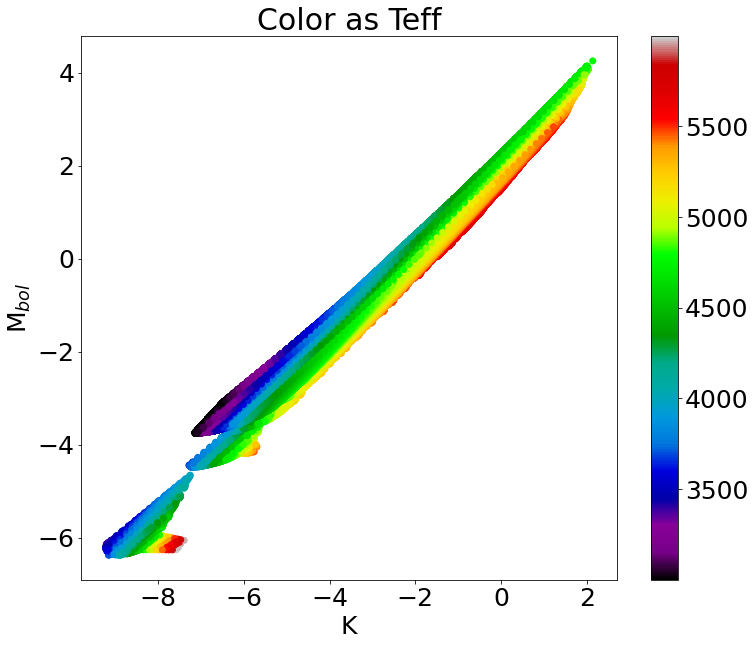

In [283]:
teffcut = np.where((massive['logTe']<=np.log10(6000))&(massive['logTe']>np.log10(3000)))
plt.figure(figsize=[12,10])
plt.scatter(massive['Ksmag'][teffcut],massive['mbolmag'][teffcut],
            c=10**massive['logTe'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Teff')
plt.xlabel(r'K')
plt.ylabel(r'M$_{bol}$')
plt.show()

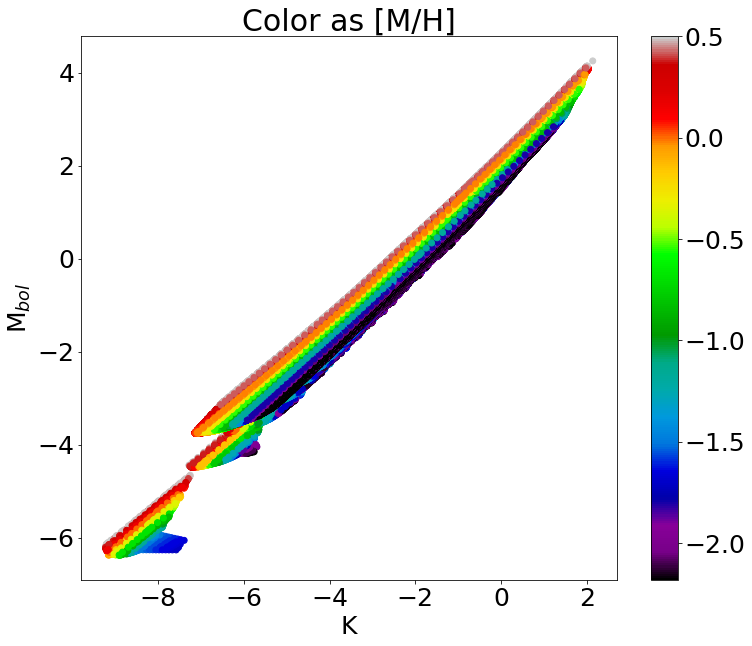

In [284]:
plt.figure(figsize=[12,10])
plt.scatter(massive['Ksmag'][teffcut],massive['mbolmag'][teffcut],c=massive['MH'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.xlabel(r'K')
plt.ylabel(r'M$_{bol}$')
plt.show()

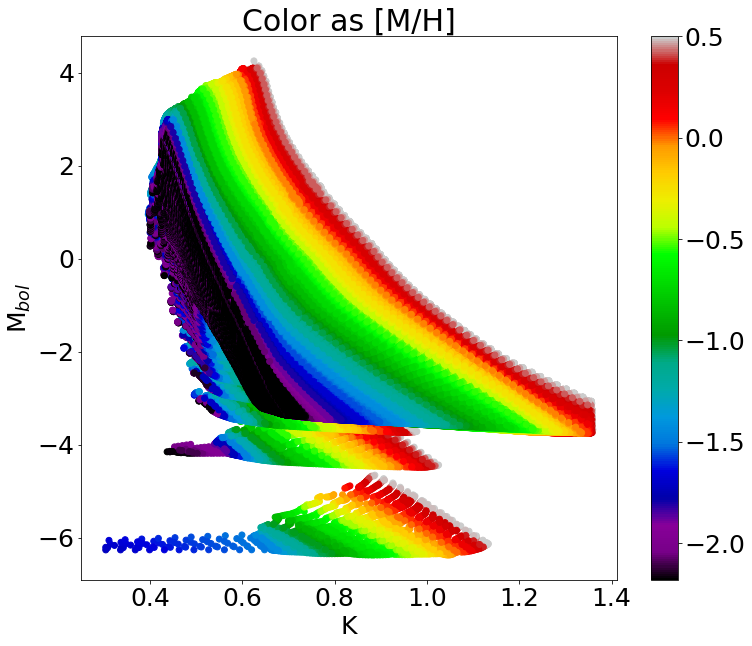

In [414]:
plt.figure(figsize=[12,10])
plt.scatter((massive['Jmag']-massive['Ksmag'])[teffcut],massive['mbolmag'][teffcut],c=massive['MH'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.xlabel(r'K')
plt.ylabel(r'M$_{bol}$')
plt.show()

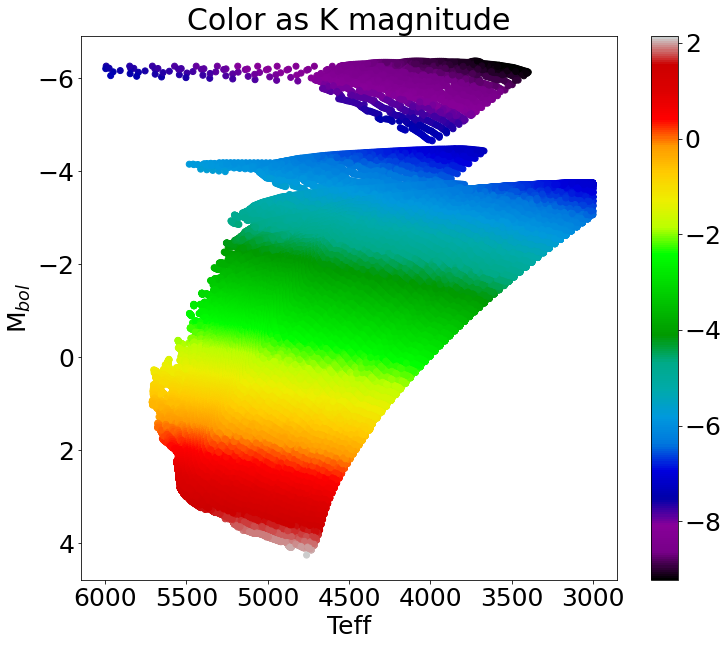

In [285]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][teffcut],massive['mbolmag'][teffcut],
            c=massive['Ksmag'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as K magnitude')
plt.xlabel(r'Teff')
plt.ylabel(r'M$_{bol}$')
plt.show()

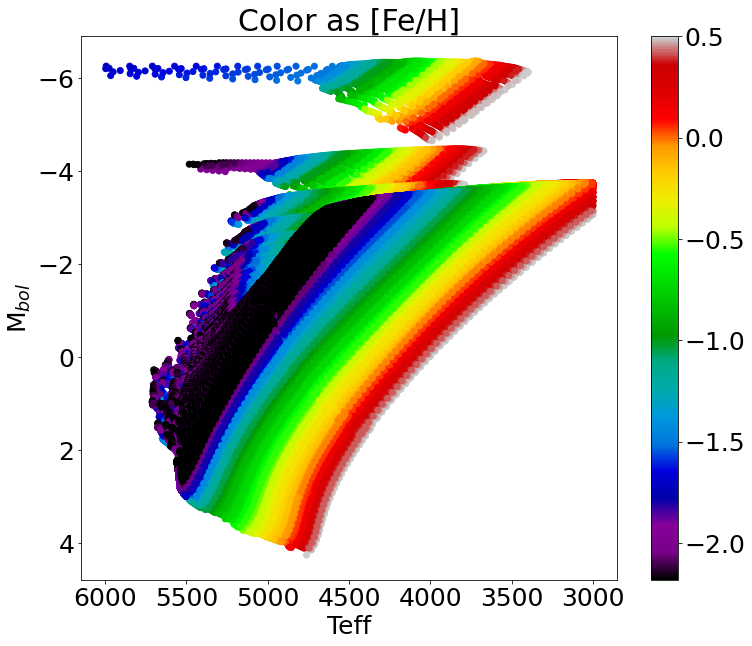

In [286]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][teffcut],massive['mbolmag'][teffcut],
            c=massive['MH'][teffcut],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Teff')
plt.ylabel(r'M$_{bol}$')
plt.show()

In [420]:
# bin_means, bin_edges, _ = binned_statistic(massive['logTe'][teffcut],
#                                            (massive['mbolmag']-massive['Ksmag'])[teffcut],
#                                            statistic='median',bins=40)
# bin_centers = (bin_edges[:-1]+np.diff(bin_edges)/2)

# def bc_k(lteff,a,b,c,d,e):
# #     lteff, feh = X
# #     return  (a + b*lteff + c*lteff**2 + d*lteff**3 + e*lteff**4 + f*lteff**5 + g*lteff**6 + h*feh + i*feh**2 + 
# #              j*feh**3 + k*feh**4 + l*feh**5 + m*feh**6)
# #     return a + b*lteff + c*lteff**2 + d*feh + e*feh**2
# #     return a + b*lteff
#     return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

# # param_labels = np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m'])
# # popt_bck, _ = curve_fit(bc_k,massive['logTe'][teffcut],(massive['mbolmag']-massive['Ksmag'])[teffcut])

# # print('Fit Parameters:')
# # for i in range(len(param_labels)):
# #     print(r'{} = {:.5f}'.format(param_labels[i],popt_bck[i]))

# param_labels = np.array(['a','b','c','d','e'])#,'f','g','h','i','j','k','l','m'])
# popt_bck, _ = curve_fit(bc_k,massive['logTe'][teffcut],(massive['mbolmag']-massive['Ksmag'])[teffcut])

# print('Fit Parameters:')
# for i in range(len(param_labels)):
#     print(r'{} = {:.5f}'.format(param_labels[i],popt_bck[i]))
    
# (a + b*lteff + c*lteff**2 + d*lteff**3 + e*lteff**4 + f*lteff**5 + g*lteff**6 + h*feh + i*feh**2 + j*feh**3 + 
# k*feh**4 + l*feh**5 + m*feh**6)
# +/- 0.025 residuals
# Fit Parameters:
# a = 1340.06248
# b = 2.22966
# c = -136.90629
# d = -394.74771
# e = 272.87382
# f = -61.78249
# g = 4.76454
# h = 0.05741
# i = 0.01135
# j = -0.06651
# k = -0.08098
# l = -0.03565
# m = -0.00551


Fit Parameters:
a = -366252.00276
b = 396402.30607
c = -160908.04863
d = 29032.51483
e = -1964.55784


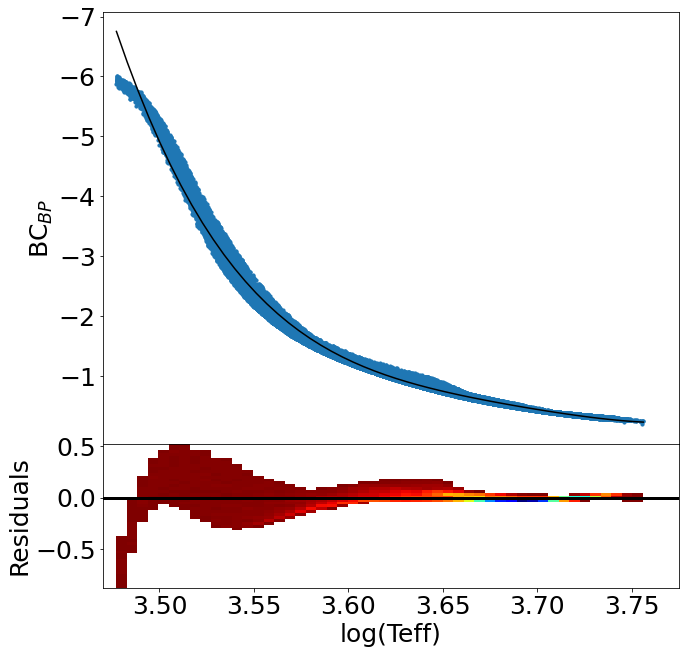

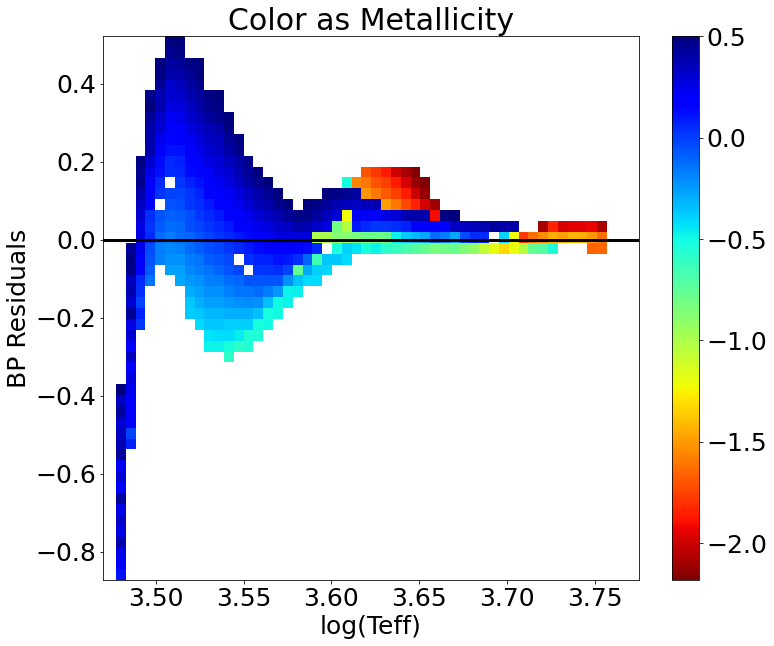

Median Residual: -0.00724 +/- 0.01768


In [452]:
def bc_bp(lteff,a,b,c,d,e):

    return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

param_labels = np.array(['a','b','c','d','e'])
popt_bcbp, _ = curve_fit(bc_bp,massive['logTe'][teffcut],(massive['mbolmag']-massive['G_BPmag'])[teffcut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_bcbp[i]))


fig1 = plt.figure(figsize=[10,10])
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.scatter(massive['logTe'][teffcut][::50],(massive['mbolmag']-massive['G_BPmag'])[teffcut][::50],s=10)

xs = np.linspace(min(massive['logTe'][teffcut][::50]),max(massive['logTe'][teffcut][::50]))
plt.plot(xs,bc_bp(xs,*popt_bcbp),c='k')

frame1.set_xticklabels([])
frame1.set_yticks([-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0])
frame1.set_ylabel(r'BC$_{BP}$')
frame1.set_xlim(3.47,3.775)
plt.gca().invert_yaxis()

#Residual plot
resid = (bc_bp(massive['logTe'][teffcut][::50],*popt_bcbp)-(massive['mbolmag']-massive['G_BPmag'])[teffcut][::50])
frame2=fig1.add_axes((.1,.1,.8,.2))

ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['logTe'][teffcut][::50],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.axhline(0,c='k',lw=3.0)

frame2.set_xlabel(r'log(Teff)')
frame2.set_ylabel(r'Residuals')
frame2.set_xlim(3.47,3.775)
plt.savefig('../plots/bc_bp_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['MH'][teffcut][::50],
                          statistic='median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.axhline(0,c='k',lw=3.0)

plt.title(r'Color as Metallicity')
plt.xlabel(r'log(Teff)')
plt.ylabel(r'BP Residuals')
plt.xlim(3.47,3.775)
plt.savefig('../plots/bc_bp_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

print('Median Residual: {:.5f} +/- {:.5f}'.format(np.nanmedian(resid),mad(resid)))

Fit Parameters:
a = -239151.74710
b = 260953.83317
c = -106795.43722
d = 19427.92610
e = -1325.55340


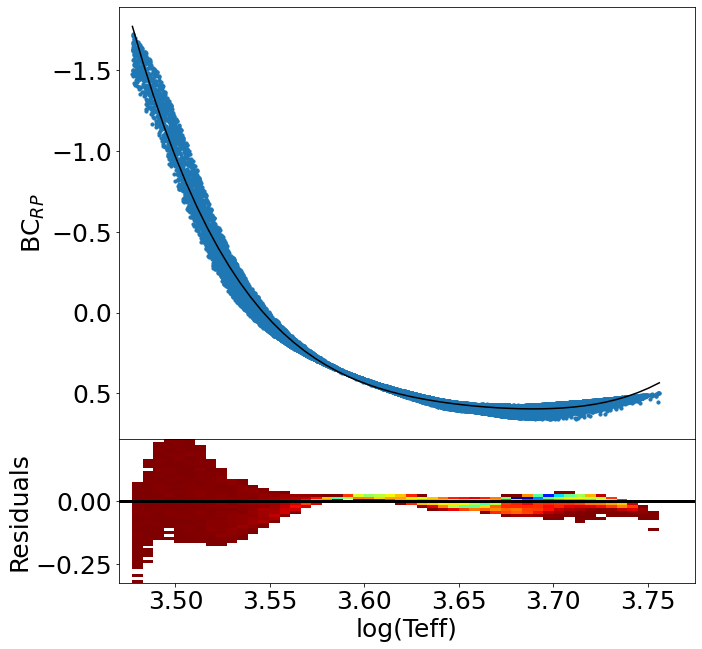

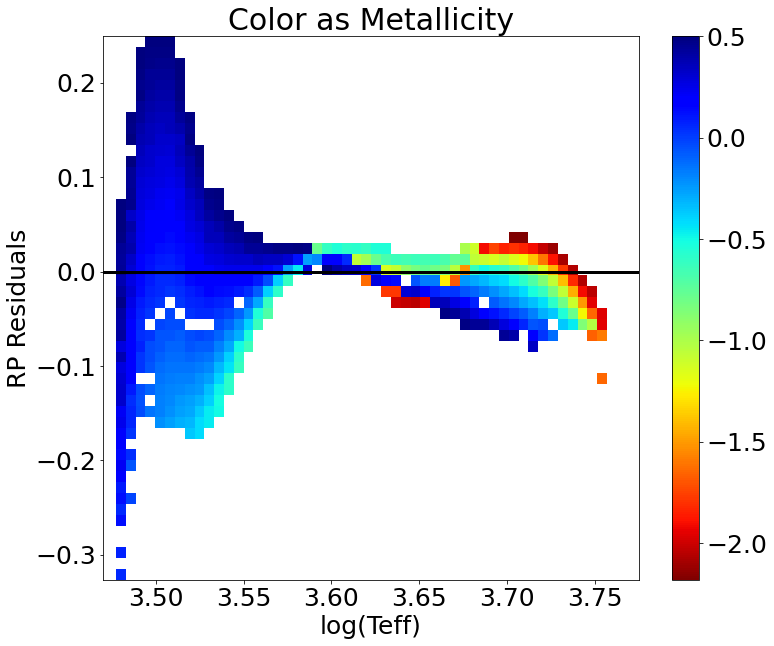

Median Residual: 0.00410 +/- 0.01379


In [453]:
def bc_rp(lteff,a,b,c,d,e):

    return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

param_labels = np.array(['a','b','c','d','e'])
popt_bcrp, _ = curve_fit(bc_rp,massive['logTe'][teffcut],(massive['mbolmag']-massive['G_RPmag'])[teffcut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_bcrp[i]))


fig1 = plt.figure(figsize=[10,10])
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.scatter(massive['logTe'][teffcut][::50],(massive['mbolmag']-massive['G_RPmag'])[teffcut][::50],s=10)

xs = np.linspace(min(massive['logTe'][teffcut][::50]),max(massive['logTe'][teffcut][::50]))
plt.plot(xs,bc_rp(xs,*popt_bcrp),c='k')

frame1.set_xticklabels([])
# frame1.set_yticks([1,2,3])
frame1.set_ylabel(r'BC$_{RP}$')
frame1.set_xlim(3.47,3.775)
plt.gca().invert_yaxis()

#Residual plot
resid = (bc_rp(massive['logTe'][teffcut][::50],*popt_bcrp)-(massive['mbolmag']-massive['G_RPmag'])[teffcut][::50])
frame2=fig1.add_axes((.1,.1,.8,.2))

ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['logTe'][teffcut][::50],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.axhline(0,c='k',lw=3.0)

frame2.set_xlabel(r'log(Teff)')
frame2.set_ylabel(r'Residuals')
frame2.set_xlim(3.47,3.775)
plt.savefig('../plots/bc_rp_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['MH'][teffcut][::50],
                          statistic='median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.axhline(0,c='k',lw=3.0)

plt.title(r'Color as Metallicity')
plt.xlabel(r'log(Teff)')
plt.ylabel(r'RP Residuals')
plt.xlim(3.47,3.775)
plt.savefig('../plots/bc_rp_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

print('Median Residual: {:.5f} +/- {:.5f}'.format(np.nanmedian(resid),mad(resid)))

Fit Parameters:
a = 38018.77275
b = -41148.61302
c = 16689.69781
d = -3006.09184
e = 202.85370


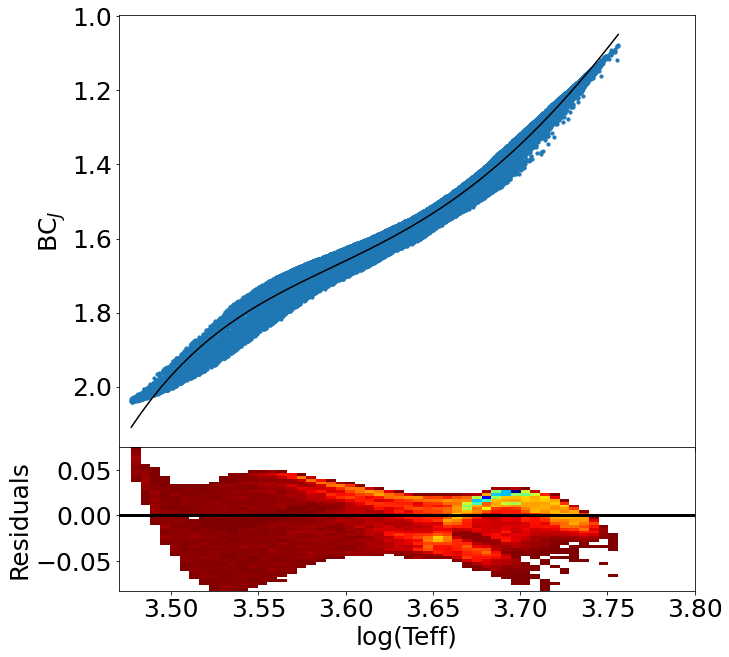

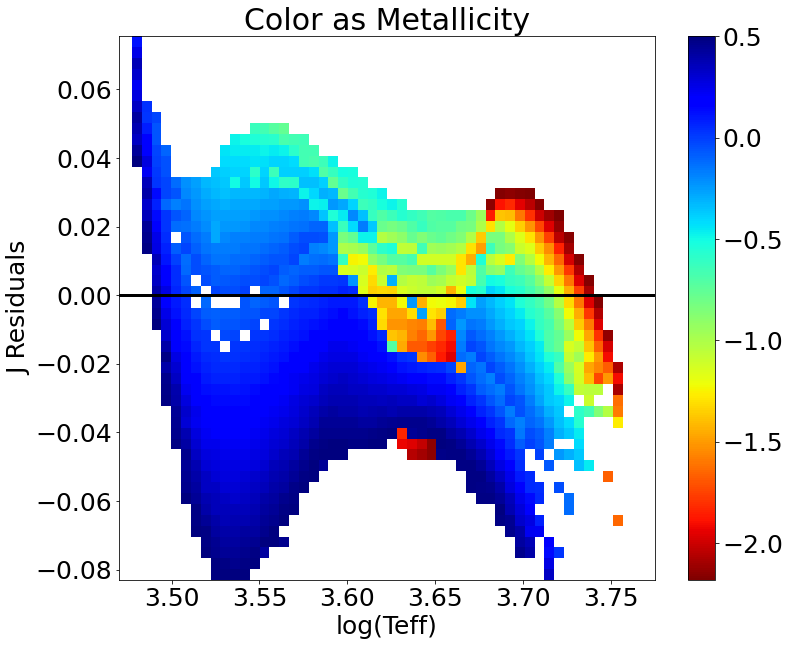

Median Residual: 0.00478 +/- 0.01531


In [454]:
def bc_j(lteff,a,b,c,d,e):

    return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

param_labels = np.array(['a','b','c','d','e'])
popt_bcj, _ = curve_fit(bc_j,massive['logTe'][teffcut],(massive['mbolmag']-massive['Jmag'])[teffcut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_bcj[i]))


fig1 = plt.figure(figsize=[10,10])
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.scatter(massive['logTe'][teffcut][::50],(massive['mbolmag']-massive['Jmag'])[teffcut][::50],s=10)

xs = np.linspace(min(massive['logTe'][teffcut][::50]),max(massive['logTe'][teffcut][::50]))
plt.plot(xs,bc_j(xs,*popt_bcj),c='k')

frame1.set_xticklabels([])
# frame1.set_yticks([1,2,3])
frame1.set_ylabel(r'BC$_J$')
frame1.set_xlim(3.47,3.8)
plt.gca().invert_yaxis()

#Residual plot
resid = (bc_j(massive['logTe'][teffcut][::50],*popt_bcj)-(massive['mbolmag']-massive['Jmag'])[teffcut][::50])
frame2=fig1.add_axes((.1,.1,.8,.2))

ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['logTe'][teffcut][::50],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.axhline(0,c='k',lw=3.0)

frame2.set_xlabel(r'log(Teff)')
frame2.set_ylabel(r'Residuals')
frame2.set_xlim(3.47,3.8)
plt.savefig('../plots/bc_j_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['MH'][teffcut][::50],
                          statistic='median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.axhline(0,c='k',lw=3.0)

plt.title(r'Color as Metallicity')
plt.xlabel(r'log(Teff)')
plt.ylabel(r'J Residuals')
plt.xlim(3.47,3.775)
plt.savefig('../plots/bc_j_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

print('Median Residual: {:.5f} +/- {:.5f}'.format(np.nanmedian(resid),mad(resid)))

Fit Parameters:
a = 45955.99702
b = -50388.99909
c = 20709.73902
d = -3780.71392
e = 258.63999


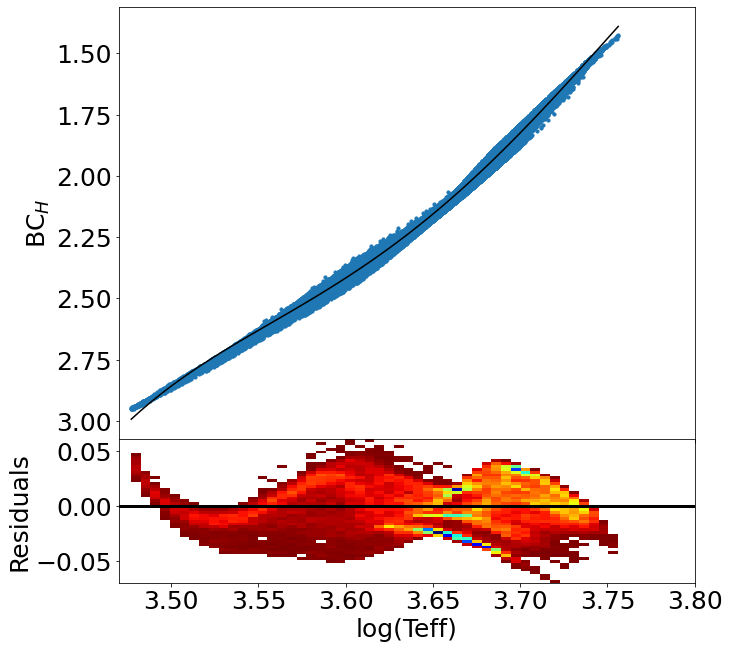

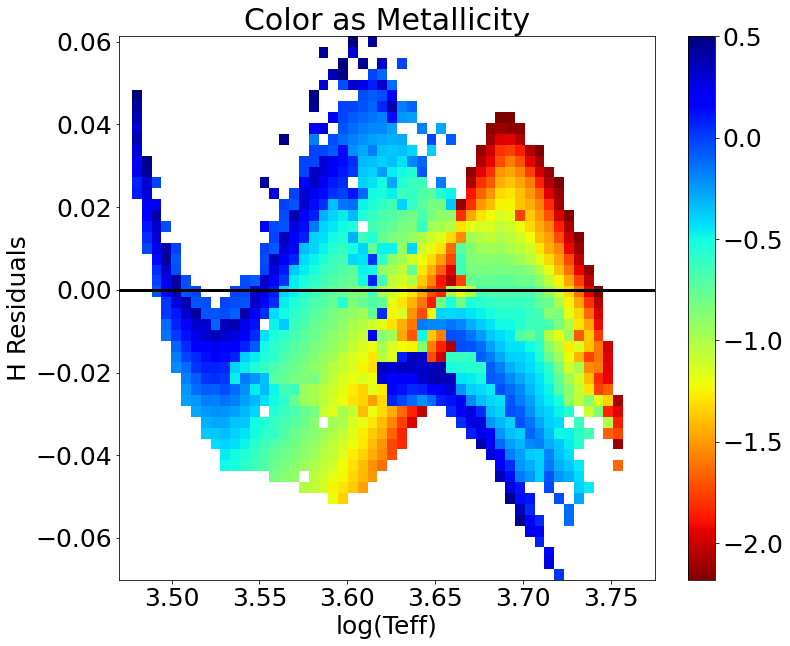

Median Residual: -0.00008 +/- 0.01508


In [455]:
def bc_h(lteff,a,b,c,d,e):

    return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

param_labels = np.array(['a','b','c','d','e'])
popt_bch, _ = curve_fit(bc_h,massive['logTe'][teffcut],(massive['mbolmag']-massive['Hmag'])[teffcut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_bch[i]))


fig1 = plt.figure(figsize=[10,10])
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.scatter(massive['logTe'][teffcut][::50],(massive['mbolmag']-massive['Hmag'])[teffcut][::50],s=10)

xs = np.linspace(min(massive['logTe'][teffcut][::50]),max(massive['logTe'][teffcut][::50]))
plt.plot(xs,bc_h(xs,*popt_bch),c='k')

frame1.set_xticklabels([])
# frame1.set_yticks([1,2,3])
frame1.set_ylabel(r'BC$_H$')
frame1.set_xlim(3.47,3.8)
plt.gca().invert_yaxis()

#Residual plot
resid = (bc_h(massive['logTe'][teffcut][::50],*popt_bch)-(massive['mbolmag']-massive['Hmag'])[teffcut][::50])
frame2=fig1.add_axes((.1,.1,.8,.2))

ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['logTe'][teffcut][::50],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.axhline(0,c='k',lw=3.0)

frame2.set_xlabel(r'log(Teff)')
frame2.set_ylabel(r'Residuals')
frame2.set_xlim(3.47,3.8)
plt.savefig('../plots/bc_h_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['MH'][teffcut][::50],
                          statistic='median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.axhline(0,c='k',lw=3.0)

plt.title(r'Color as Metallicity')
plt.xlabel(r'log(Teff)')
plt.ylabel(r'H Residuals')
plt.xlim(3.47,3.775)
plt.savefig('../plots/bc_h_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

print('Median Residual: {:.5f} +/- {:.5f}'.format(np.nanmedian(resid),mad(resid)))

Fit Parameters:
a = 15696.89389
b = -17008.41117
c = 6910.49256
d = -1247.06696
e = 84.29995


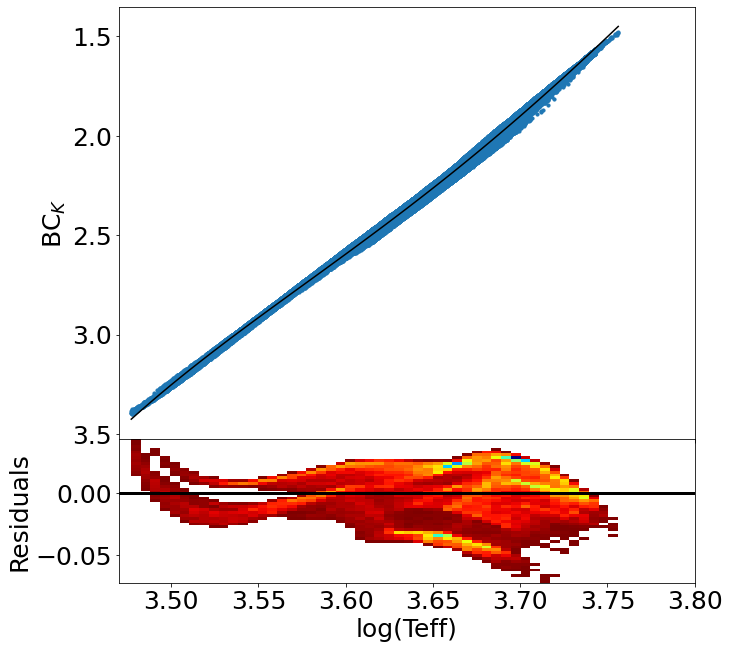

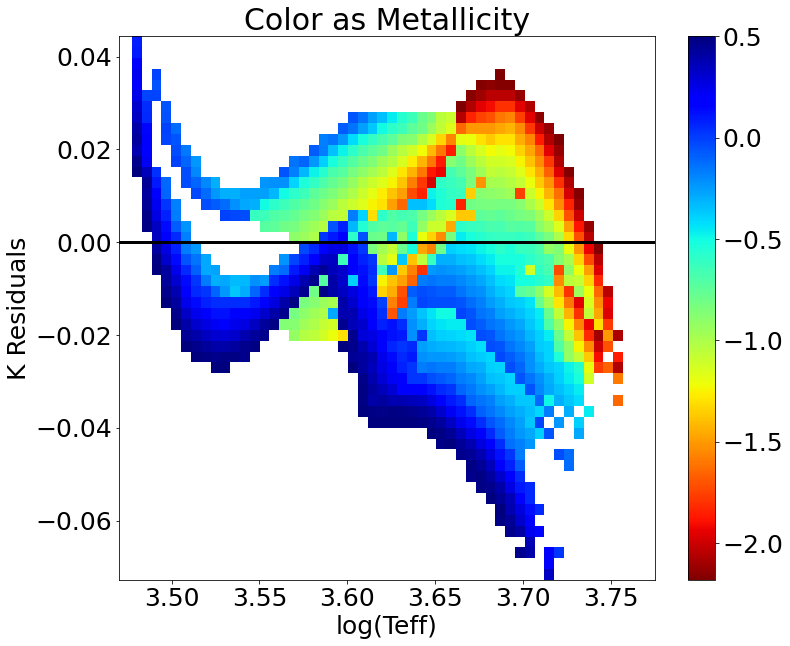

Median Residual: 0.00322 +/- 0.01474


In [456]:
def bc_k(lteff,a,b,c,d,e):

    return a+b*lteff+c*lteff**2+d*lteff**3+e*lteff**4

param_labels = np.array(['a','b','c','d','e'])
popt_bck, _ = curve_fit(bc_k,massive['logTe'][teffcut],(massive['mbolmag']-massive['Ksmag'])[teffcut])

print('Fit Parameters:')
for i in range(len(param_labels)):
    print(r'{} = {:.5f}'.format(param_labels[i],popt_bck[i]))


fig1 = plt.figure(figsize=[10,10])
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.scatter(massive['logTe'][teffcut][::50],(massive['mbolmag']-massive['Ksmag'])[teffcut][::50],s=10)

xs = np.linspace(min(massive['logTe'][teffcut][::50]),max(massive['logTe'][teffcut][::50]))
plt.plot(xs,bc_k(xs,*popt_bck),c='k')

frame1.set_xticklabels([])
# frame1.set_yticks([1,2,3])
frame1.set_ylabel(r'BC$_K$')
frame1.set_xlim(3.47,3.8)
plt.gca().invert_yaxis()

#Residual plot
resid = (bc_k(massive['logTe'][teffcut][::50],*popt_bck)-(massive['mbolmag']-massive['Ksmag'])[teffcut][::50])
frame2=fig1.add_axes((.1,.1,.8,.2))

ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['logTe'][teffcut][::50],
                          statistic='count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.axhline(0,c='k',lw=3.0)

frame2.set_xlabel(r'log(Teff)')
frame2.set_ylabel(r'Residuals')
frame2.set_xlim(3.47,3.8)
plt.savefig('../plots/bc_k_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(massive['logTe'][teffcut][::50],resid,massive['MH'][teffcut][::50],
                          statistic='median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',
           extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.axhline(0,c='k',lw=3.0)

plt.title(r'Color as Metallicity')
plt.xlabel(r'log(Teff)')
plt.ylabel(r'K Residuals')
plt.xlim(3.47,3.775)
plt.savefig('../plots/bc_k_resid.pdf',dpi=300,bbox_inches='tight')
plt.show()

print('Median Residual: {:.5f} +/- {:.5f}'.format(np.nanmedian(resid),mad(resid)))

In [331]:
10**((0.05+5.)/5.)

10.232929922807541

In [330]:
10**((-0.05+5.)/5.)

9.772372209558107

In [334]:
min((1/kdr17['GAIAEDR3_PARALLAX'])*1000)

196.67911

Text(0, 0.5, 'log(g/g$_\\odot$)')

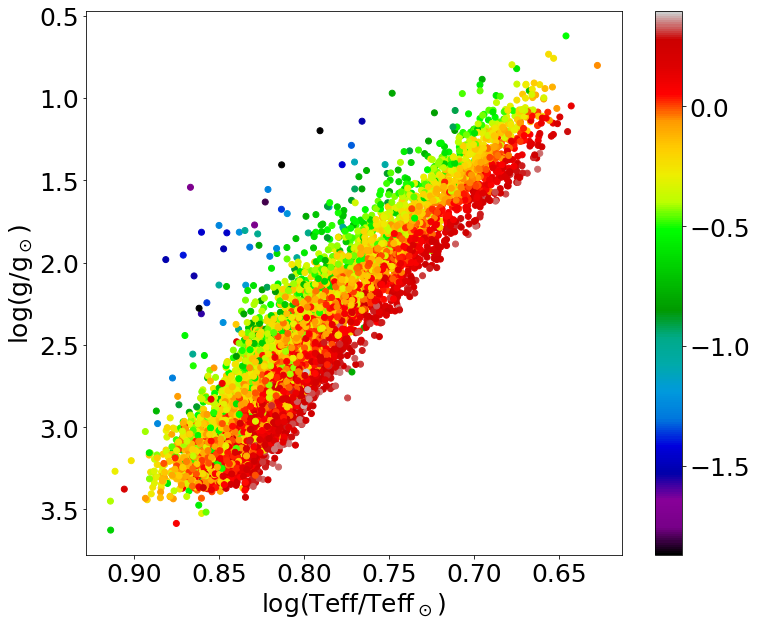

In [359]:
plt.figure(figsize=[12,10])
plt.scatter(kdr17['TEFF']/5773.,np.log10(10**kdr17['logg']/27400.)+np.log10(27400.),c=kdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'log(Teff/Teff$_\odot$)')
plt.ylabel(r'log(g/g$_\odot$)')

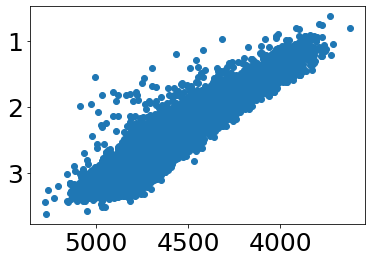

In [358]:
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [509]:
massive.columns

<TableColumns names=('index','MH','Mass','int_IMF','Mini','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag','mbolmag')>